## 黑盒攻击

### 利用样本迁移对课程模型进行黑盒攻击
- 利用本项目构建的ResNet进行样本迁移，完成对课程模型CNN的黑盒攻击
- 实验寻找I-FGSM的最佳Epsilon参数
- 最终确定为0.05作为超参数的效果较好，对样本的改动不是很大，也具有一定的攻击成功率
- Epsilon取0.05，定向攻击成功率为7.9%

cuda


C:\Users\01\AppData\Local\Temp\ipykernel_17240\1049870807.py:48: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at C:\cb\pytorch_1000000000000\work\build\aten\src\ATen/core/TensorBody.h:491.)
  if perturbed_image.grad is None:


100 of 1000 classified correctly, attack success rate is 0.090
200 of 1000 classified correctly, attack success rate is 0.090
300 of 1000 classified correctly, attack success rate is 0.097
400 of 1000 classified correctly, attack success rate is 0.092
500 of 1000 classified correctly, attack success rate is 0.082
600 of 1000 classified correctly, attack success rate is 0.085
700 of 1000 classified correctly, attack success rate is 0.081
800 of 1000 classified correctly, attack success rate is 0.083
900 of 1000 classified correctly, attack success rate is 0.080
1000 of 1000 classified correctly, attack success rate is 0.079
Epsilon: 0.01	Attack success rate: 0.0790
Success: 79	Correct: 1000
100 of 1000 classified correctly, attack success rate is 0.090
200 of 1000 classified correctly, attack success rate is 0.090
300 of 1000 classified correctly, attack success rate is 0.097
400 of 1000 classified correctly, attack success rate is 0.092
500 of 1000 classified correctly, attack success 

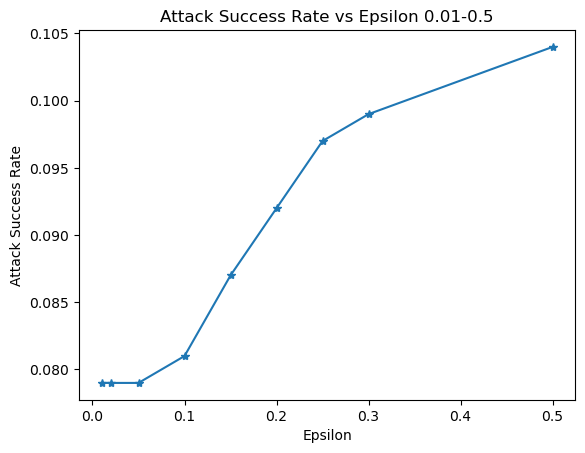

In [1]:
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
from model import CNN

transform_test = transforms.Compose([
        # transforms.ToPILImage(),
        # transforms.ToTensor(),
        transforms.Normalize(mean=(0.2860,), std=(0.3530,))
    ])
# 加载测试集
with open('../attack_data/correct_1k.pkl', 'rb') as f:
    imgs, targets=pickle.load(f)
imgs = np.array(imgs) /255
targets = np.array(targets)
imgs = torch.from_numpy(imgs).view(1000, 1, 28, 28).float()
imgs = transform_test(imgs)
targets = torch.from_numpy(targets).view(1000).long()
test_data = torch.utils.data.TensorDataset(imgs, targets)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)


# 定义攻击函数
def fgsm_attack(image, epsilon, max_iter, model, attack_model, target):
    if epsilon == 0:
            return False, perturbed_image
    perturbed_image = image
    perturbed_image.requires_grad_(True)
    perturbed_image.retain_grad()
    attack_target = ((target + 1) % 10)
    # 迭代更新扰动值
    for i in range(max_iter):
        # 计算梯度并更新扰动值
        
        output = model(perturbed_image)
        criterion = nn.CrossEntropyLoss()
        loss = criterion(output, attack_target)
        model.zero_grad()
        loss.backward()
        # print(perturbed_image.grad.size())
        if epsilon == 0:
            return False, perturbed_image
        if perturbed_image.grad is None:
            # print('attack failed, gradient is None')
            return False, perturbed_image
        data_grad = perturbed_image.grad.data
        perturbed_image = perturbed_image - epsilon * data_grad.sign()
        
        # 限制像素值范围在[0,1]
        perturbed_image = torch.clamp(perturbed_image, 0, 1)
        # 如果扰动图像已经被误分类，停止攻击
        with torch.no_grad():
            attack_output = attack_model((perturbed_image.detach() * 0.3530 + 0.2860) * 255)
            if attack_output.max(1, keepdim=True)[1] == attack_target:
                return True, perturbed_image
    print('attack failed, hava reached max iteration')
    return False, perturbed_image

# 定义测试函数
def test(model, attack_model, device, test_loader, epsilon):
    model.eval()
    attack_model.eval()
    success_num = 0
    correct = 0
    adv_examples = []
    for data, target in test_loader:
        # 找到被分类正确的图像
        # img = data.squeeze_(0).squeeze_(0)
        # plt.imshow(img, cmap='gray')
        data, target = data.to(device), target.to(device)
        with torch.no_grad():
            output = model(data.detach())
            attack_output = attack_model((data.detach() * 0.3530 + 0.2860) * 255)
        init_pred = output.max(1, keepdim=True)[1]
        init_attack_pred = attack_output.max(1, keepdim=True)[1]

        # if init_attack_pred.item() != target.item():
            # continue
        # if init_pred.item() != target.item():
            # continue
        correct += 1 # 统计分类正确的图像数量
        if correct % 500 == 0:
            print(f"{correct} of 1000 classified correctly, attack success rate is {success_num / float(correct):.3f}")

        success, perturbed_data = fgsm_attack(image=data, epsilon=epsilon, max_iter=100, model=model, attack_model=attack_model, target=target)
        if success:
            success_num += 1
            adv_examples.append((data, perturbed_data, target))

    # 计算攻击成功率
    attack_acc = success_num / float(correct)
    print(f"Epsilon: {epsilon}\tAttack success rate: {attack_acc:.4f}")
    print(f"Success: {success_num}\tCorrect: {correct}")
    return attack_acc, adv_examples

# 设置攻击参数
device = torch.device("cuda" if torch.cuda.is_available() else "mps")
print(device)
epsilons = [0.01, 0.02, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.5]
# 0.001最优
attack_accs = []
examples = []

# 加载模型
model = torchvision.models.resnet34(weights=None, num_classes=10)
model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.fc = nn.Linear(model.fc.in_features, 10)  # 更改最后一层全连接层
model.load_state_dict(torch.load('../checkpoints/checkpoint-60-93.71.pt', map_location=device))
model.to(device)

attack_model = CNN()
attack_model.load_state_dict(torch.load('../model/cnn.ckpt', map_location=device))
attack_model.to(device)
# 对模型进行测试和攻击

for eps in epsilons:
    acc, ex = test(model, attack_model, device, test_loader, eps)
    attack_accs.append(acc)
    examples.append(ex)
    if not os.path.exists('../attack_data/black'):
        os.makedirs('../attack_data/black')    
    torch.save(ex, f'../attack_data/black/eps-{eps:.3f}-ASR-{acc:.3f}.pt')

torch.save(examples, '../attack_data/black/attack_examples.pt')

# plt.figure(figsize=(5,5))
plt.plot(epsilons, attack_accs, "*-")
# plt.yticks(np.arange(0, 1.1, step=0.1))
# plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Attack Success Rate vs Epsilon 0.01-0.5")
plt.xlabel("Epsilon")
plt.ylabel("Attack Success Rate")
plt.show()

#### 成功攻击样本的展示

- Epsilon取0.5的攻击成功率最高为10.4%，但是对样本的改动已经很大

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
攻击样本数量：
104


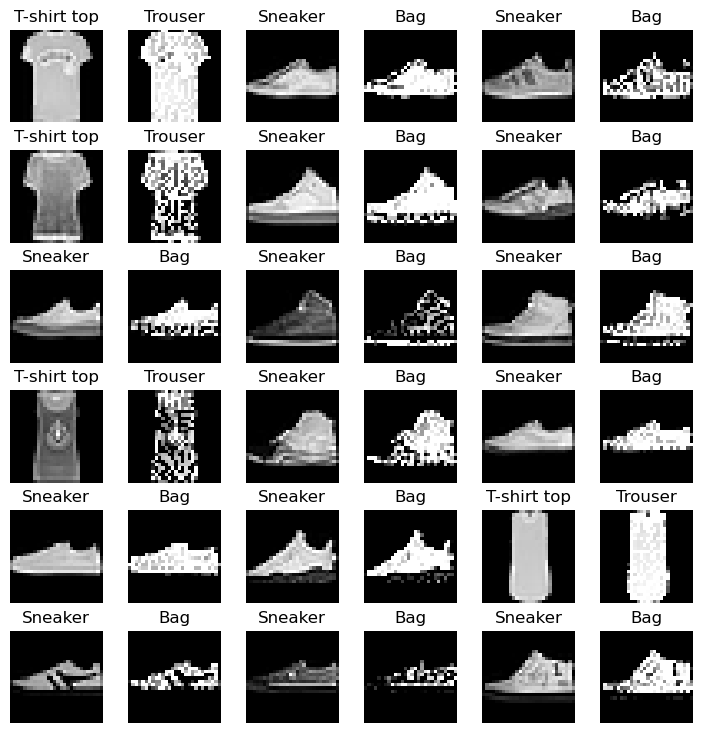

In [2]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch
import torchvision
import numpy as np
import random

# 加载测试集类别
test_data = torchvision.datasets.FashionMNIST(root='../data', train=False, download=True, transform=transforms.ToTensor())
class_names = list(test_data.classes)
print(class_names)
# adv_examples = torch.load('../attack_data/black/eps-0.500-ASR-0.096.pt')
adv_examples = torch.load('../attack_data/black/eps-0.500-ASR-0.104.pt')
print('攻击样本数量：')
print(len(adv_examples))
random.seed(2244)
random.shuffle(adv_examples)
class_names[0] = 'T-shirt top'
torch.manual_seed(2023)
fig = plt.figure(figsize=(9, 9))
rows, cols = 6, 6
cnt = 1
for i, (data, perturbed_data, target) in enumerate(adv_examples):
    if cnt > rows * cols:
        break
    random_idx = target.item()
    fig.add_subplot(rows, cols, cnt)
    plt.imshow(data.cpu().detach().numpy().squeeze(), cmap="gray")
    plt.title(class_names[random_idx])
    plt.axis(False)
    # plt.imsave(f'../images/Black-N{cnt // 2}-Original-{random_idx}-{class_names[random_idx]}.png', data.cpu().detach().numpy().squeeze())
    cnt += 1

    fig.add_subplot(rows, cols, cnt)
    plt.imshow(perturbed_data.cpu().detach().numpy().squeeze(), cmap="gray")
    attack_target = (random_idx + 1) % 10
    plt.title(class_names[attack_target])
    plt.axis(False)
    # plt.imsave(f'../images/Black-N{(cnt-1) // 2}-Perturbed-{attack_target}-{class_names[attack_target]}.png', perturbed_data.cpu().detach().numpy().squeeze())
    cnt += 1
fig.subplots_adjust(hspace=0.3, wspace=0.1)

- Epsilon取0.05对样本的改动较小，且仍有一定的攻击效果，攻击成功率为7.9%

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
攻击样本数量：
79


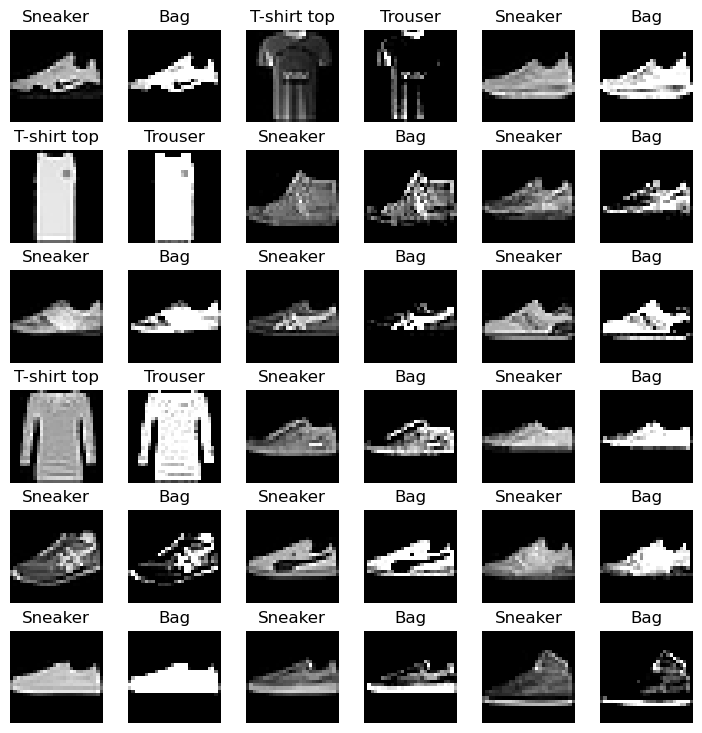

In [7]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch
import torchvision
import numpy as np
import random

# 加载测试集类别
test_data = torchvision.datasets.FashionMNIST(root='../data', train=False, download=True, transform=transforms.ToTensor())
class_names = list(test_data.classes)
print(class_names)
adv_examples = torch.load('../attack_data/black/eps-0.050-ASR-0.079.pt')
print('攻击样本数量：')
print(len(adv_examples))
random.seed(1911)
random.shuffle(adv_examples)
class_names[0] = 'T-shirt top'
torch.manual_seed(2023)
fig = plt.figure(figsize=(9, 9))
rows, cols = 6, 6
cnt = 1
for i, (data, perturbed_data, target) in enumerate(adv_examples):
    if cnt > rows * cols:
        break
    random_idx = target.item()
    fig.add_subplot(rows, cols, cnt)
    plt.imshow(data.cpu().detach().numpy().squeeze(), cmap="gray")
    plt.title(class_names[random_idx])
    plt.axis(False)
    plt.imsave(f'../images/Black-N{cnt // 2}-Original-{random_idx}-{class_names[random_idx]}.png', data.cpu().detach().numpy().squeeze())
    cnt += 1

    fig.add_subplot(rows, cols, cnt)
    plt.imshow(perturbed_data.cpu().detach().numpy().squeeze(), cmap="gray")
    attack_target = (random_idx + 1) % 10
    plt.title(class_names[attack_target])
    plt.axis(False)
    plt.imsave(f'../images/Black-N{(cnt-1) // 2}-Perturbed-{attack_target}-{class_names[attack_target]}.png', perturbed_data.cpu().detach().numpy().squeeze())
    cnt += 1
fig.subplots_adjust(hspace=0.3, wspace=0.1)

## 基于MCMC采样对项目本模型进行黑盒攻击

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision
import random
import pickle
import datetime

def attack_mcmc(data, target, model, device, max_step = 500, std = 0.03, thres_d = 0.05):
    attack_target = (target + 1) % 10
    for i in range(max_step):
        # transition
        # data_new = torch.normal(data, std=std).to(device)
        u = torch.rand(1, device=device)
        data_new = torch.normal(data, std=std).to(device)
        with torch.no_grad():
            pred = F.softmax(model(data_new), dim=-1)
        y_prime = pred[0][attack_target]
        if y_prime >= u:
            continue
        # print(f"l1-loss: \r{F.l1_loss(data_new, data, reduction='mean')}")
        if F.l1_loss(data_new, data, reduction='mean') > thres_d:
            continue
        data = data_new
        label = model(data).max(1, keepdim=True)[1]
        if label == attack_target:
            print(f"attack success at step {i}, init label: {target.item()} current label: {label.item()}")
            return True, data
    return False, data

transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.2860,), std=(0.3530,))
    ])
# 加载测试集
test_data = torchvision.datasets.FashionMNIST(root='../data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)

# 设置加速
device = torch.device("cuda" if torch.cuda.is_available() else "mps")
print(device)
# 加载模型
model = torchvision.models.resnet34(weights=None, num_classes=10)
model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.fc = nn.Linear(model.fc.in_features, 10)  # 更改最后一层全连接层
model.load_state_dict(torch.load('../checkpoints/checkpoint-60-93.71.pt', map_location=device))
model.to(device)

success_num = 0
correct = 0
adv_examples = []
model.eval()

for (img, label) in test_loader:
    img = img.to(device)
    label = label.to(device)
    output = model(img)
    init_pred = output.max(1, keepdim=True)[1]
    if init_pred.item() != label.item():
        continue
    correct = correct + 1
    # if correct > 1000:
        # break
    res, attack_img = attack_mcmc(img, label, model, device, max_step=300, std=0.02, thres_d=0.05)
    if res:
        adv_examples.append((img.cpu().detach().numpy().squeeze(), attack_img.cpu().detach().numpy().squeeze(), label.item()))
        success_num = success_num + 1
    if correct % 100 == 0:
        print(f"correct: {correct} success: {success_num}")
# 输出攻击成功率
print(f"attack success radio: {success_num / 1000}")
current_time = datetime.datetime.now()
with open(f"../attack_data/ResNet-black-MCMC-{current_time.strftime('%H-%M')}.pkl", 'wb') as f:
    pickle.dump(adv_examples, f)

mps
attack success at step 4, init label: 7 current label: 8
attack success at step 4, init label: 7 current label: 8
attack success at step 9, init label: 7 current label: 8
attack success at step 19, init label: 7 current label: 8
attack success at step 5, init label: 7 current label: 8
attack success at step 142, init label: 7 current label: 8
attack success at step 16, init label: 7 current label: 8
attack success at step 13, init label: 7 current label: 8
attack success at step 7, init label: 7 current label: 8
correct: 100 success: 9
attack success at step 5, init label: 7 current label: 8
attack success at step 10, init label: 7 current label: 8
attack success at step 20, init label: 7 current label: 8
attack success at step 24, init label: 7 current label: 8
attack success at step 3, init label: 7 current label: 8
attack success at step 11, init label: 7 current label: 8
attack success at step 29, init label: 9 current label: 0
attack success at step 8, init label: 7 current la

KeyboardInterrupt: 

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
17


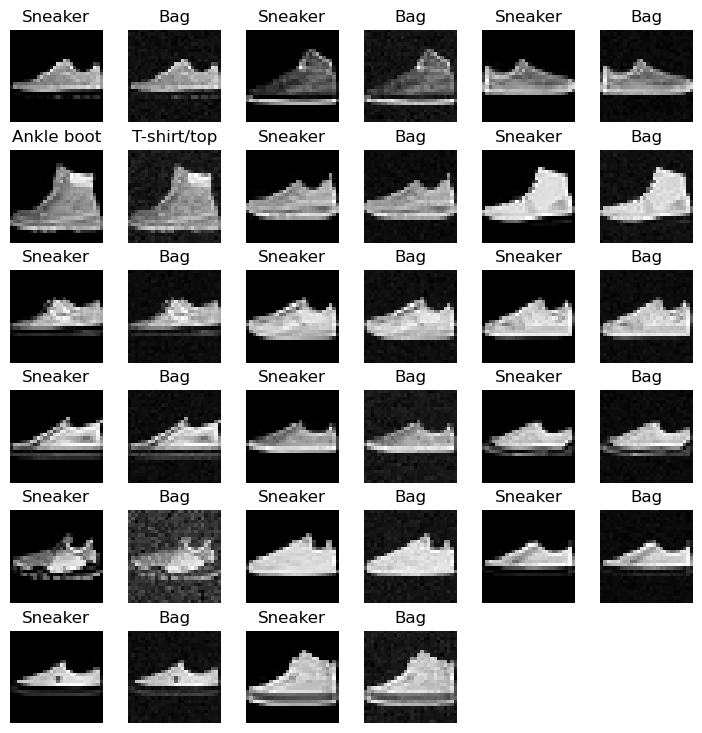

In [2]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch
import torchvision
import numpy as np
import random
import pickle
current_time = datetime.datetime.now()
with open(f"../attack_data/ResNet-black-MCMC-{current_time.strftime('%H-%M')}.pkl", 'wb') as f:
    pickle.dump(adv_examples, f)
# 加载测试集类别
test_data = torchvision.datasets.FashionMNIST(root='../data', train=False, download=True, transform=transforms.ToTensor())
class_names = list(test_data.classes)
print(class_names)

adv_examples = []
with open(f"../attack_data/ResNet-black-MCMC-22-43.pkl", 'rb') as f:
    adv_examples = pickle.load(f)
print(len(adv_examples))
random.seed(2023)
random.shuffle(adv_examples)

torch.manual_seed(2023)
fig = plt.figure(figsize=(9, 9))
rows, cols = 6, 6
cnt = 1
for i, (data, perturbed_data, target) in enumerate(adv_examples):
    if cnt > rows * cols:
        break
    random_idx = target
    fig.add_subplot(rows, cols, cnt)
    plt.imshow(data, cmap="gray")
    plt.title(class_names[random_idx])
    plt.axis(False)
    # plt.imsave(f'../images/White-N{cnt // 2}-Original-{random_idx}-{class_names[random_idx]}.png', data.cpu().detach().numpy().squeeze())
    cnt += 1

    fig.add_subplot(rows, cols, cnt)
    plt.imshow(perturbed_data, cmap="gray")
    attack_target = (random_idx + 1) % 10
    plt.title(class_names[attack_target])
    plt.axis(False)
    # plt.imsave(f'../images/White-N{(cnt-1) // 2}-Perturbed-{attack_target}-{class_names[attack_target]}.png', perturbed_data.cpu().detach().numpy().squeeze())
    cnt += 1
fig.subplots_adjust(hspace=0.3, wspace=0.1)

## 基于MCMC采样对课程模型进行黑盒攻击

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision
import numpy as np
from model import CNN
import pickle
import datetime

def attack_mcmc(data, target, model, device, max_step = 200, std = 0.03, thres_d = 0.1):
    attack_target = (target + 1) % 10
    for i in range(max_step):
        # transition
        # data_new = torch.normal(data, std=std).to(device)
        u = torch.rand(1, device=device)
        data_new = torch.normal(data, std=std).to(device)
        with torch.no_grad():
            pred = F.softmax(model(data_new), dim=-1)
        y_prime = pred[0][attack_target]
        if y_prime >= u:
            continue
        # print(f"l1-loss: \r{F.l1_loss(data_new, data, reduction='mean')}")
        if F.l1_loss(data_new, data, reduction='mean') > thres_d:
            continue
        data = data_new
        label = model(data).max(1, keepdim=True)[1]
        if label == attack_target:
            print(f"attack success at step {i}, init label: {target.item()} current label: {label.item()}")
            return True, data
    return False, data

transform_test = transforms.Compose([
        # transforms.ToPILImage(),
        # transforms.ToTensor(),
        transforms.Normalize(mean=(0.2860,), std=(0.3530,))
    ])
# 加载测试集
with open('../attack_data/correct_1k.pkl', 'rb') as f:
    imgs, targets=pickle.load(f)
imgs = np.array(imgs) /255
targets = np.array(targets)
imgs = torch.from_numpy(imgs).view(1000, 1, 28, 28).float()
targets = torch.from_numpy(targets).view(1000).long()
test_data = torch.utils.data.TensorDataset(imgs, targets)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)

# 设置加速
device = torch.device("cuda" if torch.cuda.is_available() else "mps")
print(device)
# 加载模型
# model = torchvision.models.resnet34(weights=None, num_classes=10)
# model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
# model.fc = nn.Linear(model.fc.in_features, 10)  # 更改最后一层全连接层
model = CNN()
model.load_state_dict(torch.load('../model/cnn.ckpt'))
model.to(device)

success_num = 0
correct = 0
adv_examples = []
model.eval()

for (img, label) in test_loader:
    img = img.to(device)
    label = label.to(device)
    output = model(img)
    init_pred = output.max(1, keepdim=True)[1]
    if init_pred.item() != label.item():
        continue
    correct = correct + 1
    if correct > 1000:
        break
    res, attack_img = attack_mcmc(img, label, model, device, max_step=300, std=0.02, thres_d=0.05)
    if res:
        adv_examples.append((img.cpu().detach().numpy().squeeze(), attack_img.cpu().detach().numpy().squeeze(), label.item()))
        success_num = success_num + 1
    if correct % 100 == 0:
        print(f"correct: {correct} success: {success_num}")
# 输出攻击成功率
print(f"attack success radio: {success_num / 1000}")
current_time = datetime.datetime.now()
with open(f"../attack_data/CNN-black-MCMC-{current_time.strftime('%H-%M')}.pkl", 'wb') as f:
    pickle.dump(adv_examples, f)

mps
attack success at step 82, init label: 7 current label: 8
attack success at step 173, init label: 7 current label: 8
attack success at step 56, init label: 7 current label: 8
attack success at step 162, init label: 7 current label: 8
attack success at step 64, init label: 7 current label: 8
attack success at step 34, init label: 7 current label: 8
attack success at step 30, init label: 7 current label: 8
attack success at step 34, init label: 7 current label: 8
attack success at step 28, init label: 9 current label: 0
attack success at step 104, init label: 7 current label: 8
attack success at step 75, init label: 7 current label: 8
attack success at step 44, init label: 7 current label: 8
attack success at step 213, init label: 7 current label: 8
attack success at step 50, init label: 7 current label: 8
attack success at step 36, init label: 7 current label: 8
attack success at step 57, init label: 2 current label: 3
attack success at step 56, init label: 9 current label: 0
attack

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
104


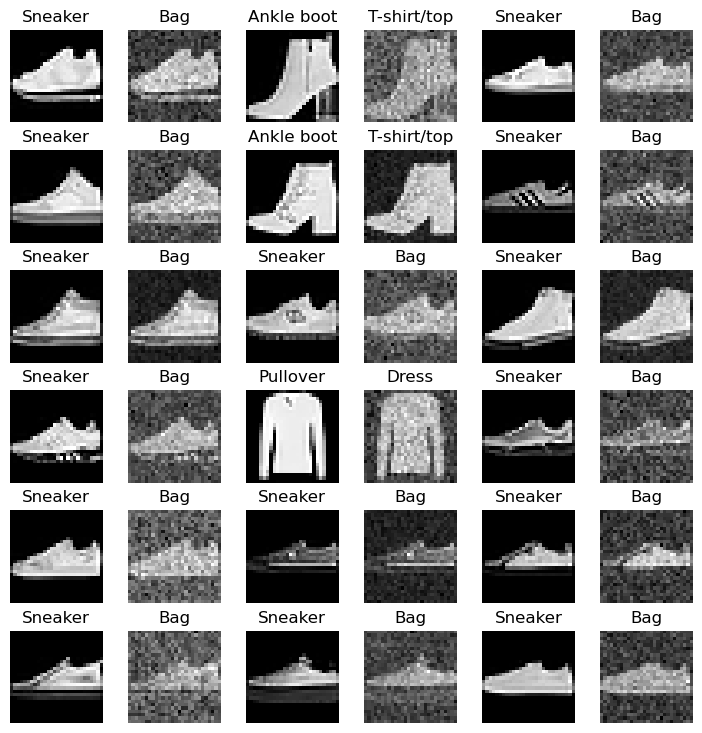

In [20]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch
import torchvision
import numpy as np
import random
import pickle

# 加载测试集类别
test_data = torchvision.datasets.FashionMNIST(root='../data', train=False, download=True, transform=transforms.ToTensor())
class_names = list(test_data.classes)
print(class_names)

adv_examples = []
with open(f"../attack_data/CNN-black-MCMC-01-47.pkl", 'rb') as f:
    adv_examples = pickle.load(f)
print(len(adv_examples))
random.seed(2023)
random.shuffle(adv_examples)

torch.manual_seed(2023)
fig = plt.figure(figsize=(9, 9))
rows, cols = 6, 6
cnt = 1
for i, (data, perturbed_data, target) in enumerate(adv_examples):
    if cnt > rows * cols:
        break
    random_idx = target
    fig.add_subplot(rows, cols, cnt)
    plt.imshow(data, cmap="gray")
    plt.title(class_names[random_idx])
    plt.axis(False)
    # plt.imsave(f'../images/White-N{cnt // 2}-Original-{random_idx}-{class_names[random_idx]}.png', data.cpu().detach().numpy().squeeze())
    cnt += 1

    fig.add_subplot(rows, cols, cnt)
    plt.imshow(perturbed_data, cmap="gray")
    attack_target = (random_idx + 1) % 10
    plt.title(class_names[attack_target])
    plt.axis(False)
    # plt.imsave(f'../images/White-N{(cnt-1) // 2}-Perturbed-{attack_target}-{class_names[attack_target]}.png', perturbed_data.cpu().detach().numpy().squeeze())
    cnt += 1
fig.subplots_adjust(hspace=0.3, wspace=0.1)